In [1]:

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import matplotlib.pyplot as plt
#import seaborn as sns

# 1. Load and normalize the data
X = np.load("X.npy")  # Shape: (N, 1000, 12)
y = np.load("y.npy")  # Shape: (N, 2000, 12)
#y = y[:, :1000, :]
y = y[:, 600:1200, :]

# Normalize features across all samples and timesteps
X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X = (X - X_mean) / (X_std + 1e-8)

y_mean = y.mean(axis=(0, 1), keepdims=True)
y_std = y.std(axis=(0, 1), keepdims=True)
y = (y - y_mean) / (y_std + 1e-8)

# 2. Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 3. Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 4. Define gru model with Dropout
class GRUPredictor(nn.Module):
    def __init__(self, input_size=12, hidden_size=384, num_layers=3, dropout=0.3, output_seq_len=2000):
        super(GRUPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq_len = output_seq_len
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 6)
    )
    def forward(self, x):
        out, _ = self.gru(x)               # out shape: (batch, 300, hidden)
        out = self.fc(out)                  # out shape: (batch, 300, 18)
        return out



# 5. Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUPredictor().to(device)
#weights = torch.tensor([770, 45, 1.05])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [2]:
# 6. Training loop
best_val_loss = float("inf")
best_model_path = "best_gru_model.pth"
for epoch in range(1, 81):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y[:, :, [0, 1, 4, 5, 8, 9]])
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                val_loss += criterion(outputs, val_y[:, :, [0, 1, 4, 5, 8, 9]]).item()
        val_loss /= len(val_loader)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best: {best_val_loss:.4f}")

Epoch 1, Training Loss: 0.5131, Val Loss: 0.5856, Best: 0.5856
Epoch 10, Training Loss: 0.1296, Val Loss: 0.0902, Best: 0.0902
Epoch 20, Training Loss: 0.0554, Val Loss: 0.0621, Best: 0.0621
Epoch 30, Training Loss: 0.0460, Val Loss: 0.0521, Best: 0.0521
Epoch 40, Training Loss: 0.0310, Val Loss: 0.0432, Best: 0.0432
Epoch 50, Training Loss: 0.0241, Val Loss: 0.0371, Best: 0.0371
Epoch 60, Training Loss: 0.0204, Val Loss: 0.0349, Best: 0.0349
Epoch 70, Training Loss: 0.0288, Val Loss: 0.0422, Best: 0.0349
Epoch 80, Training Loss: 0.0121, Val Loss: 0.0320, Best: 0.0320


In [3]:
model = GRUPredictor(input_size=12, hidden_size=384, num_layers=3, dropout=0.3).to(device)
model.load_state_dict(torch.load("best_gru_model.pth"))
model.eval()
total_mse = total_mae = 0
r2_scores = []

with torch.no_grad():
    for val_X, val_y in val_loader:
        val_X, val_y = val_X.to(device), val_y.to(device)
        
        outputs = model(val_X)  # (B, 300, 6)
        target_pos = val_y[:, :, [0, 1, 4, 5, 8, 9]]  # (B, 300, 6)

        total_mse += nn.functional.mse_loss(outputs, target_pos, reduction='sum').item()
        total_mae += nn.functional.l1_loss(outputs, target_pos, reduction='sum').item()

        pred_np = outputs.cpu().numpy().reshape(-1, 6)
        true_np = target_pos.cpu().numpy().reshape(-1, 6)
        r2_scores.append(r2_score(true_np, pred_np))

avg_mse = total_mse / len(val_dataset)
avg_mae = total_mae / len(val_dataset)
avg_r2 = np.mean(r2_scores)

print(f"\nValidation MSE: {avg_mse:.4f}")
print(f"Validation MAE: {avg_mae:.4f}")
print(f"Validation R² Score: {avg_r2:.4f}")


Validation MSE: 114.5565
Validation MAE: 385.2043
Validation R² Score: 0.9640


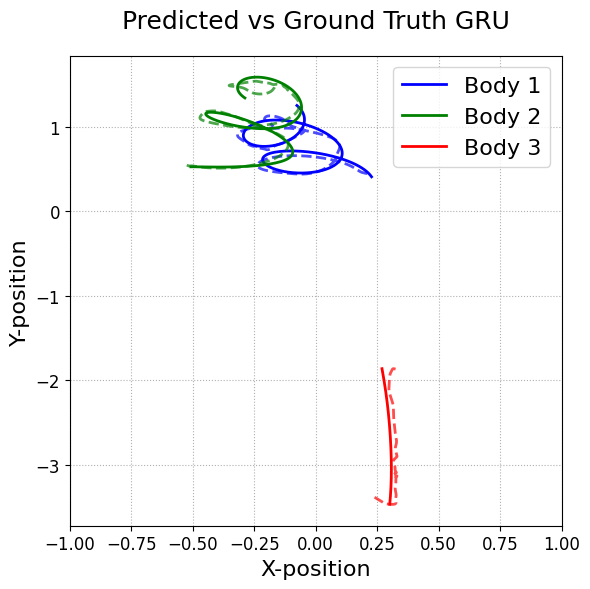

600


In [ ]:
model = GRUPredictor(input_size=12, hidden_size=384, num_layers=3, dropout=0.3).to(device)
model.load_state_dict(torch.load("best_gru_model.pth"))
model.eval()

X = np.load("X.npy")
y = np.load("y.npy")
y = y[:, 600:1200, :]  # du predikterar bara sista halvan

X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X_norm = (X - X_mean) / (X_std + 1e-8)

y_mean = y.mean(axis=(0, 1), keepdims=True)
y_std = y.std(axis=(0, 1), keepdims=True)


i = 541 #16
input_seq = torch.tensor(X_norm[i], dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    pred_norm = model(input_seq).squeeze(0).cpu().numpy()  # shape: (300, 6)

idx = [0, 1, 4, 5, 8, 9]
y_true = y[i][:, idx]
y_pred = pred_norm * y_std.squeeze()[idx] + y_mean.squeeze()[idx]

fig, ax = plt.subplots(figsize=(6,6))
labels = ['Body 1', 'Body 2', 'Body 3']
colors = ['blue', 'green', 'red']
for k in range(3):
        x_true = y_true[:, k*2]
        y_true_k = y_true[:, k*2+1]
        x_pred = y_pred[:, k*2]
        y_pred_k = y_pred[:, k*2+1]

        # True trajectory – solid
        ax.plot(x_true, y_true_k, color="black", label = labels[k], linewidth=2)

        # Prediction – dashed
        ax.plot(x_pred, y_pred_k, linestyle='--', color=colors[k], linewidth=2, alpha=0.7)

ax.set_title("Predicted vs Ground Truth GRU", fontsize=18, pad=20)
ax.set_xlabel("X-position", fontsize=16)
ax.set_ylabel("Y-position", fontsize=16)
ax.tick_params(labelsize=12)
#ax.axis("equal")
plt.xlim(-1,1)
ax.legend(fontsize =16)

ax.grid(True, linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()
print(len(y[i]))

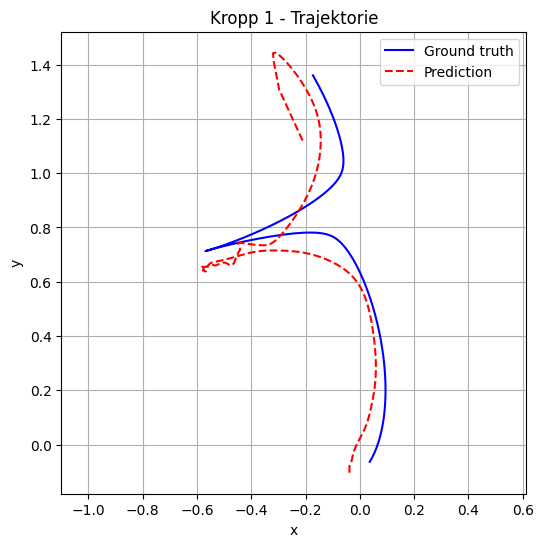

In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Ladda modellen
model = GRUPredictor(input_size=12, hidden_size=384, num_layers=3, dropout=0.3).to(device)
model.load_state_dict(torch.load("best_gru_model.pth"))
model.eval()

# 2. Normalisera input
X = np.load("X.npy")
y = np.load("y.npy")
y = y[:, 600:1200, :]  # prediktion för framtid

X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X_norm = (X - X_mean) / (X_std + 1e-8)

y_mean = y.mean(axis=(0, 1), keepdims=True)
y_std = y.std(axis=(0, 1), keepdims=True)

# 3. Välj sample och kropp
i = 267 # 21 , 261 sample index
body_index = 0 # 0 = kropp 1, 1 = kropp 2, 2 = kropp 3

# 4. Förbered input
input_seq = torch.tensor(X_norm[i], dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    pred_norm = model(input_seq).squeeze(0).cpu().numpy()  # (300, 6)

# 5. Avnormalisera
idx = [0, 1, 4, 5, 8, 9]  # x,y för kroppar
y_true = y[i][:, [idx[body_index * 2], idx[body_index * 2 + 1]]]
y_pred = pred_norm[:, body_index * 2:body_index * 2 + 2]
y_pred = y_pred * y_std.squeeze()[[idx[body_index * 2], idx[body_index * 2 + 1]]] + \
         y_mean.squeeze()[[idx[body_index * 2], idx[body_index * 2 + 1]]]

# 6. Plot
plt.figure(figsize=(6, 6))
plt.plot(y_true[:, 0], y_true[:, 1], label="Ground truth", color='blue')
plt.plot(y_pred[:, 0], y_pred[:, 1], '--', label="Prediction", color='red')
plt.title(f"Kropp {body_index + 1} - Trajektorie")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()
